# 4.4 Practical Exercises: First set
For this first set of exercises, the relevant dataset is available via the following link: Click here to see and download the dataset

• Collect the relevant dataset from the given Dataset folder, and handle the missing values in this dataset.

• Are there any outliers in the dataset? If yes, remove the outliers.

• Normalize the appropriate features and show the results.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

file_path = "cervical-cancer_csv.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df = df.replace('?', np.nan)

year_columns = [
    'Smokes (years)',
    'Hormonal Contraceptives (years)',
    'IUD (years)',
    'STDs: Time since first diagnosis',
    'STDs: Time since last diagnosis'
]

features_to_process = [
    'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies',
    'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)',
    'IUD (years)', 'STDs (number)', 'STDs: Time since first diagnosis',
    'STDs: Time since last diagnosis'
]

df_cleaned = df.copy()

for col in features_to_process:
    s = df_cleaned[col].dropna() # Use non-NaN values for calculation
    
    if not s.empty:
        Q1 = s.quantile(0.25)
        Q3 = s.quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the outliers (Winsorization)
        # Values below the lower bound are set to the lower bound
        df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col])
        # Values above the upper bound are set to the upper bound
        df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])

scaler = MinMaxScaler()

# for col in features_to_process:
    # Scale only the non-NaN values (NaNs will remain NaN)
    # non_nan_mask = df_cleaned[col].notna()
    # data_to_scale = df_cleaned[col][non_nan_mask].values.reshape(-1, 1)
    
    # # Apply the scaler and place the scaled values back
    # df_cleaned.loc[non_nan_mask, col] = scaler.fit_transform(data_to_scale).flatten()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# df_cleaned[year_columns] = df_cleaned[year_columns].apply(np.floor).astype('Int64')

print("\nDataFrame Head after Outlier Capping and Min-Max Normalization:")
print(df_scaled[features_to_process].head())

df_scaled.to_csv('cervical-cancer_cleaned_normalized.csv', index=False)


print("done")




DataFrame Head after Outlier Capping and Min-Max Normalization:
   Number of sexual partners  First sexual intercourse  Num of pregnancies  \
0                   0.857143                  0.375000            0.166667   
1                   0.000000                  0.291667            0.166667   
2                   0.000000                       NaN            0.166667   
3                   1.000000                  0.458333            0.666667   
4                   0.571429                  0.875000            0.666667   

   Smokes (years)  Smokes (packs/year)  Hormonal Contraceptives (years)  \
0             0.0                  0.0                              0.0   
1             0.0                  0.0                              0.0   
2             0.0                  0.0                              0.0   
3             0.0                  0.0                              0.4   
4             0.0                  0.0                              1.0   

   IUD (years) 

# 5.6 Practical Exercises: Second set
For this second set of exercises, the relevant dataset is available via the following link: Click here to see and download the dataset

1. For the dataset, check the feature type and convert them into appropriate format.
2. Apply suitable encoding techniques to relevant features, making them suitable for machine
learning algorithms.
3. Show the feature interaction and polynomial features for the dataset.
4. Select the important features from the selected dataset.
5. Reduce the dimensionality using the PCA technique. Observe and comment on your resutls.

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

file_path = "kidney_disease.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

df = df.replace(['\t?', '\t', '?', ''], np.nan)
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# --- 1. Feature Type Conversion ---
# Convert columns that should be numeric
numeric_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert binary/ordinal categorical columns
binary_map_yes_no = {'yes': 1, 'no': 0}
df['htn'] = df['htn'].map(binary_map_yes_no)
df['dm'] = df['dm'].map(binary_map_yes_no)
df['cad'] = df['cad'].map(binary_map_yes_no)
df['pe'] = df['pe'].map(binary_map_yes_no)
df['ane'] = df['ane'].map(binary_map_yes_no)
df['appet'] = df['appet'].map({'good': 1, 'poor': 0})
df['pcc'] = df['pcc'].map({'present': 1, 'notpresent': 0})
df['ba'] = df['ba'].map({'present': 1, 'notpresent': 0})

# Convert target variable
df['classification'] = df['classification'].map({'ckd': 1, 'notckd': 0})

print("### 1. Data Types after Conversion ###")
print(df.info())
print("\n" + "="*50 + "\n")

# --- 1.5. Imputation (Necessary for ML algorithms) ---
# We must fill missing values before proceeding
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].mean(), inplace=True)
    
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("### Data Head after Imputation (Mean/Mode) ###")
print(df.head())
print("\n" + "="*50 + "\n")

# --- 2. Categorical Encoding (rbc, pc) ---
# Note: pcc and ba were already handled in step 1
encode_cols = ['rbc', 'pc']
le = LabelEncoder()

for col in encode_cols:
    df[col] = le.fit_transform(df[col])
    # le.classes_ shows what was encoded (e.g., 'abnormal' -> 0, 'normal' -> 1)
    print(f"Encoding for '{col}': {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\n### 2. Data Head after Label Encoding 'rbc' and 'pc' ###")
print(df.head())
print("\n" + "="*50 + "\n")

# --- 3. Feature Interaction and Polynomial Features ---
# Separate features (X) and target (y)
X = df.drop('classification', axis=1)
y = df['classification']

# Standardize data *before* polynomial features (good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Create Polynomial Features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly_features = poly.fit_transform(X_scaled)

# Get names for the new features
poly_feature_names = poly.get_feature_names_out(X.columns)
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

print("### 3. Polynomial Features (Degree 2) ###")
print(f"Original features: {X_scaled.shape[1]}")
print(f"New total features (with interactions/polynomials): {df_poly.shape[1]}")
print("First 5 rows and 5 columns of the new polynomial features:")
print(df_poly.iloc[:, :5].head())
print("\n" + "="*50 + "\n")


# --- 4. Select Important Features ---
# We use SelectKBest with the ANOVA F-test (f_classif)
# Let's select the top 20 features
k_best = 20
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X, y)

# Get the names of the selected features
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
df_selected = pd.DataFrame(X_selected, columns=selected_features)

print(f"### 4. Selected Top {k_best} Features ###")
print("Selected feature names:")
print(list(selected_features))
print("\nHead of selected feature data:")
print(df_selected.head())
print("\n" + "="*50 + "\n")

# --- 5. Reduce Dimensionality using PCA ---
# Note: The data (df_selected) is already scaled from the polynomial step.
# We will run PCA to capture 95% of the variance.
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df_selected)

# Create a new DataFrame for the PCA components
pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_cols)

# Add the target variable back for the final file
df_pca['classification'] = y

print("### 5. PCA Results and Commentary ###")
print(f"Original number of features (from Step 4): {df_selected.shape[1]}")
print(f"Number of PCA components to explain 95% variance: {pca.n_components_}")
print(f"Total variance explained by these components: {pca.explained_variance_ratio_.sum() * 100:.2f}%")
print("\nHead of final PCA-transformed data:")
print(df_pca.head())
print("\n" + "="*50 + "\n")

# --- Final Export ---
output_filename = 'kidney_disease_processed_pca.csv'
df_pca.to_csv(output_filename, index=False)

print(f"✅ Successfully processed data and exported to '{output_filename}'")

### 1. Data Types after Conversion ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    float64
 8   ba              396 non-null    float64
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 

/tmp/ipykernel_3045240/2161752541.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_3045240/2161752541.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

# 6.3 Practical Exercises: Third set
The relevant dataset is available via the following link: Click here to see and download the dataset
1. Show the correlation among all the features in the dataset and explain the results.
2. Show the descriptive statistics for all the features.
3. Check all the numeric features to see whether they are normally distributed or not.
4. Draw box plots for all the numeric features and explain the results.
5. Draw count plots for all the categorical features and interpret the results.

c:\Users\alvan\OneDrive\Documents\Engineering - Fourth Year\CME-465\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


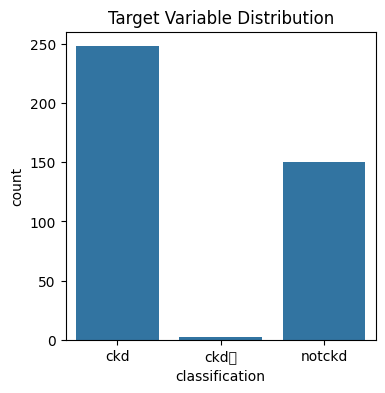

C:\Users\alvan\AppData\Local\Temp\ipykernel_6720\3766671706.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)
C:\Users\alvan\AppData\Local\Temp\ipykernel_6720\3766671706.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

--- Data Cleaning and Preparation Complete ---
Numeric Features: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
Categorical Features: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']


--- 1. Correlation Matrix ---
Correlation heatmap saved as 'correlation_heatmap.png'.
See the heatmap image for correlation results.

Example Interpretation:
Correlation 'hemo' and 'pcv': 0.85 (Strong positive)
Correlation 'hemo' and 'classification': -0.73 (Strong negative)




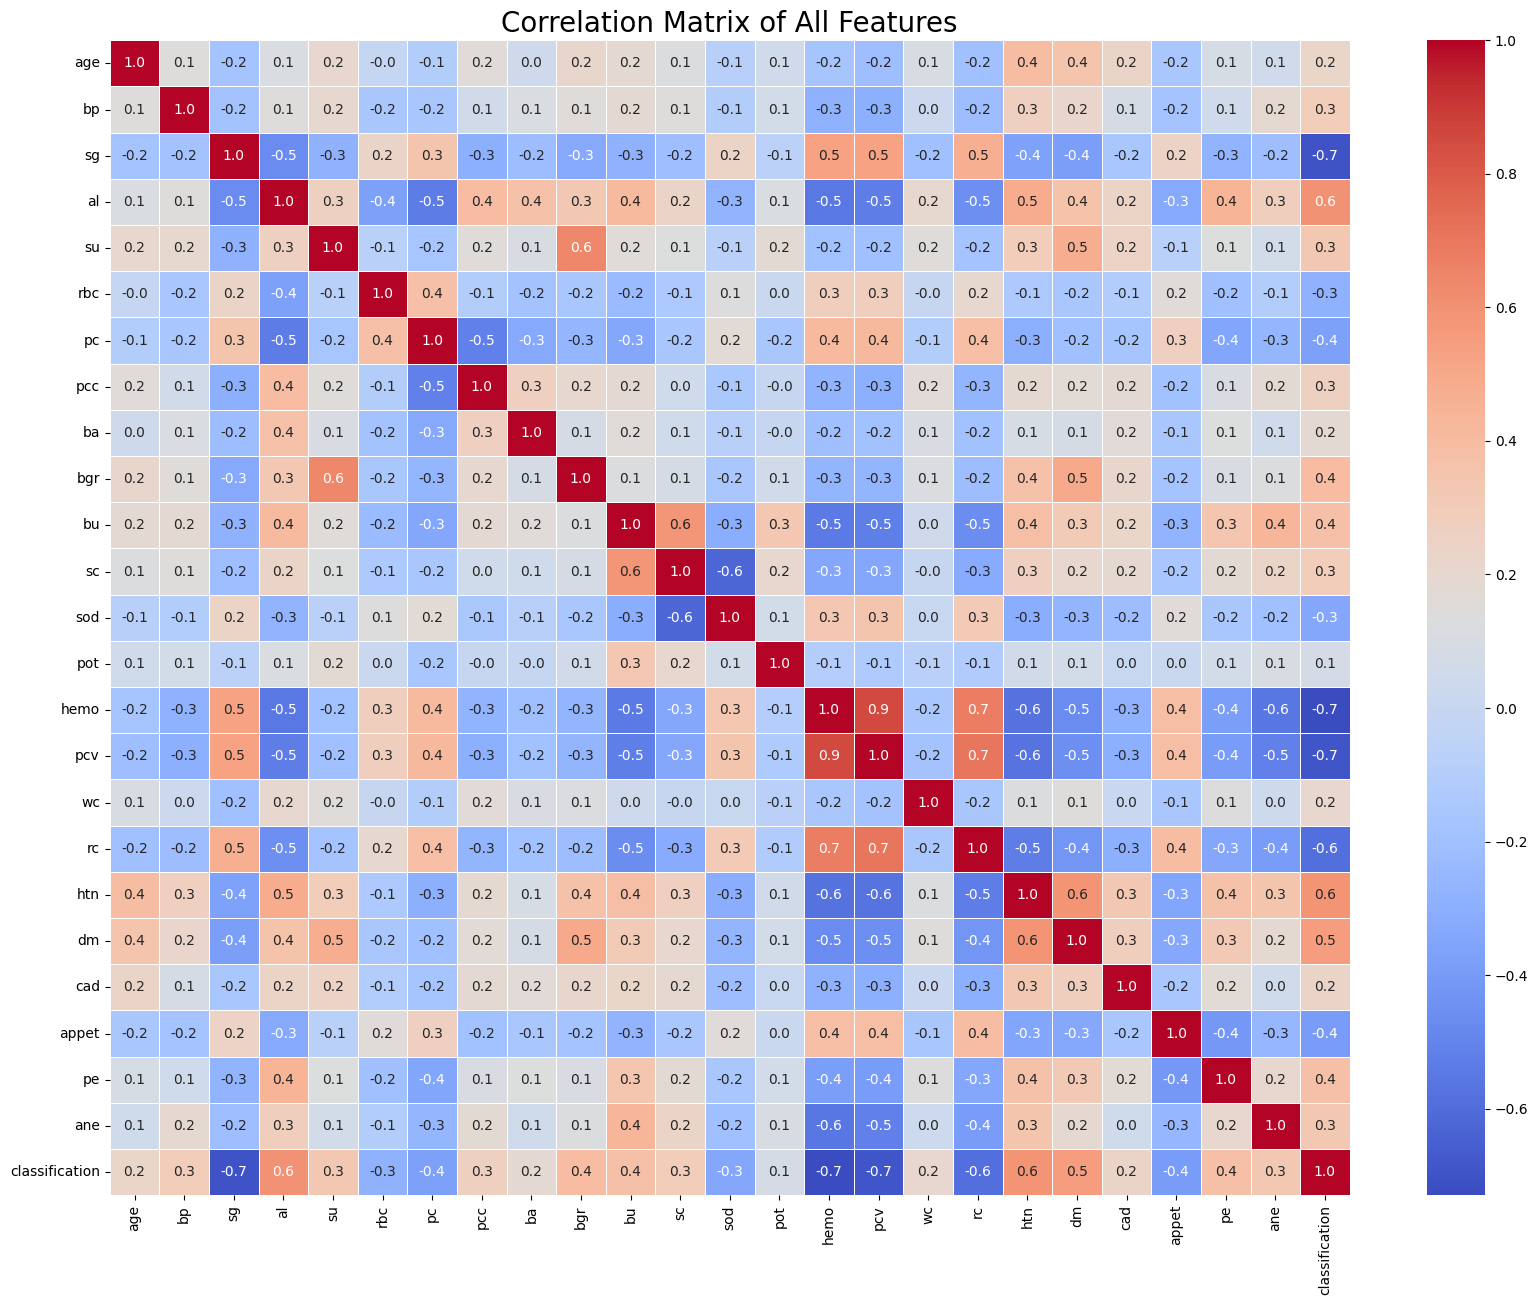

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

file_path = "kidney_disease.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

df = df.replace(['\t?', '\t', '?', ''], np.nan)
if 'id' in df.columns:
    df = df.drop('id', axis=1)



# --- 1. Feature Type Conversion ---
# Convert columns that should be numeric
numeric_cols_to_convert = ['pcv', 'wc', 'rc']
for col in numeric_cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Define explicit mappings for categorical variables to 0/1
binary_map_yes_no = {'yes': 1, 'no': 0}
binary_map_present = {'present': 1, 'notpresent': 0}
binary_map_normal = {'normal': 1, 'abnormal': 0}
binary_map_appet = {'good': 1, 'poor': 0}
binary_map_target = {'ckd': 1, 'notckd': 0}

df['htn'] = df['htn'].map(binary_map_yes_no)
df['dm'] = df['dm'].map(binary_map_yes_no)
df['cad'] = df['cad'].map(binary_map_yes_no)
df['pe'] = df['pe'].map(binary_map_yes_no)
df['ane'] = df['ane'].map(binary_map_yes_no)
df['pcc'] = df['pcc'].map(binary_map_present)
df['ba'] = df['ba'].map(binary_map_present)
df['rbc'] = df['rbc'].map(binary_map_normal)
df['pc'] = df['pc'].map(binary_map_normal)
df['appet'] = df['appet'].map(binary_map_appet)
df['classification'] = df['classification'].map(binary_map_target)

# Define feature lists for separation
all_numeric_features = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
all_categorical_features = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']

# --- Imputation (Required for correlations and tests) ---
df_cleaned = df.copy()

# Impute numeric with mean
for col in all_numeric_features:
    df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)

# Impute categorical with mode
for col in all_categorical_features:
    # Check if 'classification' column exists before imputing
    if col in df_cleaned.columns:
        df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

# Ensure categorical columns are integer type after imputation
for col in all_categorical_features:
    if col in df_cleaned.columns:
        # Use nullable Int64 type
        df_cleaned[col] = df_cleaned[col].astype('Int64')

print("--- Data Cleaning and Preparation Complete ---")
print(f"Numeric Features: {all_numeric_features}")
print(f"Categorical Features: {all_categorical_features}")
print("\n" + "="*50 + "\n")




# --- Task 1: Correlation Among All Features ---
print("--- 1. Correlation Matrix ---")
corr_matrix = df_cleaned.corr()

# Plotting the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of All Features', fontsize=20)
plt.savefig('correlation_heatmap.png', bbox_inches='tight')
print("Correlation heatmap saved as 'correlation_heatmap.png'.")
print("See the heatmap image for correlation results.")
print("\nExample Interpretation:")
print(f"Correlation 'hemo' and 'pcv': {corr_matrix.loc['hemo', 'pcv']:.2f} (Strong positive)")
print(f"Correlation 'hemo' and 'classification': {corr_matrix.loc['hemo', 'classification']:.2f} (Strong negative)")
print("\n" + "="*50 + "\n")

In [15]:
# --- Task 2: Descriptive Statistics ---
print("--- 2. Descriptive Statistics for All Features ---")
# include='all' provides stats for both numeric and categorical (encoded) features
desc_stats = df_cleaned.describe(include='all')
print(desc_stats)
print("\n" + "="*50 + "\n")

--- 2. Descriptive Statistics for All Features ---
              age          bp          sg          al          su       rbc  \
count  400.000000  400.000000  400.000000  400.000000  400.000000     400.0   
mean    51.483376   76.469072    1.017408    1.016949    0.450142    0.8825   
std     16.974966   13.476298    0.005369    1.272318    1.029487  0.322418   
min      2.000000   50.000000    1.005000    0.000000    0.000000       0.0   
25%     42.000000   70.000000    1.015000    0.000000    0.000000       1.0   
50%     54.000000   78.234536    1.017408    1.000000    0.000000       1.0   
75%     64.000000   80.000000    1.020000    2.000000    0.450142       1.0   
max     90.000000  180.000000    1.025000    5.000000    5.000000       1.0   

             pc       pcc        ba         bgr  ...         pcv  \
count     400.0     400.0     400.0  400.000000  ...  400.000000   
mean       0.81     0.105     0.055  148.036517  ...   38.884498   
std    0.392792  0.306937  0.2282

In [16]:
# --- Task 3: Normality Check (Numeric Features) ---
print("--- 3. Normality Check (Shapiro-Wilk Test) ---")
print("H0: The data is normally distributed. (p > 0.05)")
print("H1: The data is NOT normally distributed. (p <= 0.05)")
normality_results = {}
for col in all_numeric_features:
    # Shapiro test requires at least 3 samples
    if df_cleaned[col].nunique() > 1 and len(df_cleaned[col].dropna()) > 3:
        stat, p_value = stats.shapiro(df_cleaned[col].dropna())
        normality_results[col] = p_value
        if p_value > 0.05:
            print(f"'{col}': p-value = {p_value:.4f} (Likely Normally Distributed)")
        else:
            print(f"'{col}': p-value = {p_value:.4f} (Likely NOT Normally Distributed)")
    else:
        print(f"'{col}': Skipped (not enough unique data for test)")
print("\n" + "="*50 + "\n")

--- 3. Normality Check (Shapiro-Wilk Test) ---
H0: The data is normally distributed. (p > 0.05)
H1: The data is NOT normally distributed. (p <= 0.05)
'age': p-value = 0.0000 (Likely NOT Normally Distributed)
'bp': p-value = 0.0000 (Likely NOT Normally Distributed)
'sg': p-value = 0.0000 (Likely NOT Normally Distributed)
'al': p-value = 0.0000 (Likely NOT Normally Distributed)
'su': p-value = 0.0000 (Likely NOT Normally Distributed)
'bgr': p-value = 0.0000 (Likely NOT Normally Distributed)
'bu': p-value = 0.0000 (Likely NOT Normally Distributed)
'sc': p-value = 0.0000 (Likely NOT Normally Distributed)
'sod': p-value = 0.0000 (Likely NOT Normally Distributed)
'pot': p-value = 0.0000 (Likely NOT Normally Distributed)
'hemo': p-value = 0.0002 (Likely NOT Normally Distributed)
'pcv': p-value = 0.0000 (Likely NOT Normally Distributed)
'wc': p-value = 0.0000 (Likely NOT Normally Distributed)
'rc': p-value = 0.0000 (Likely NOT Normally Distributed)




--- 4. Generating Box Plots for Numeric Features ---
Numeric feature box plots saved as 'numeric_boxplots.png'.




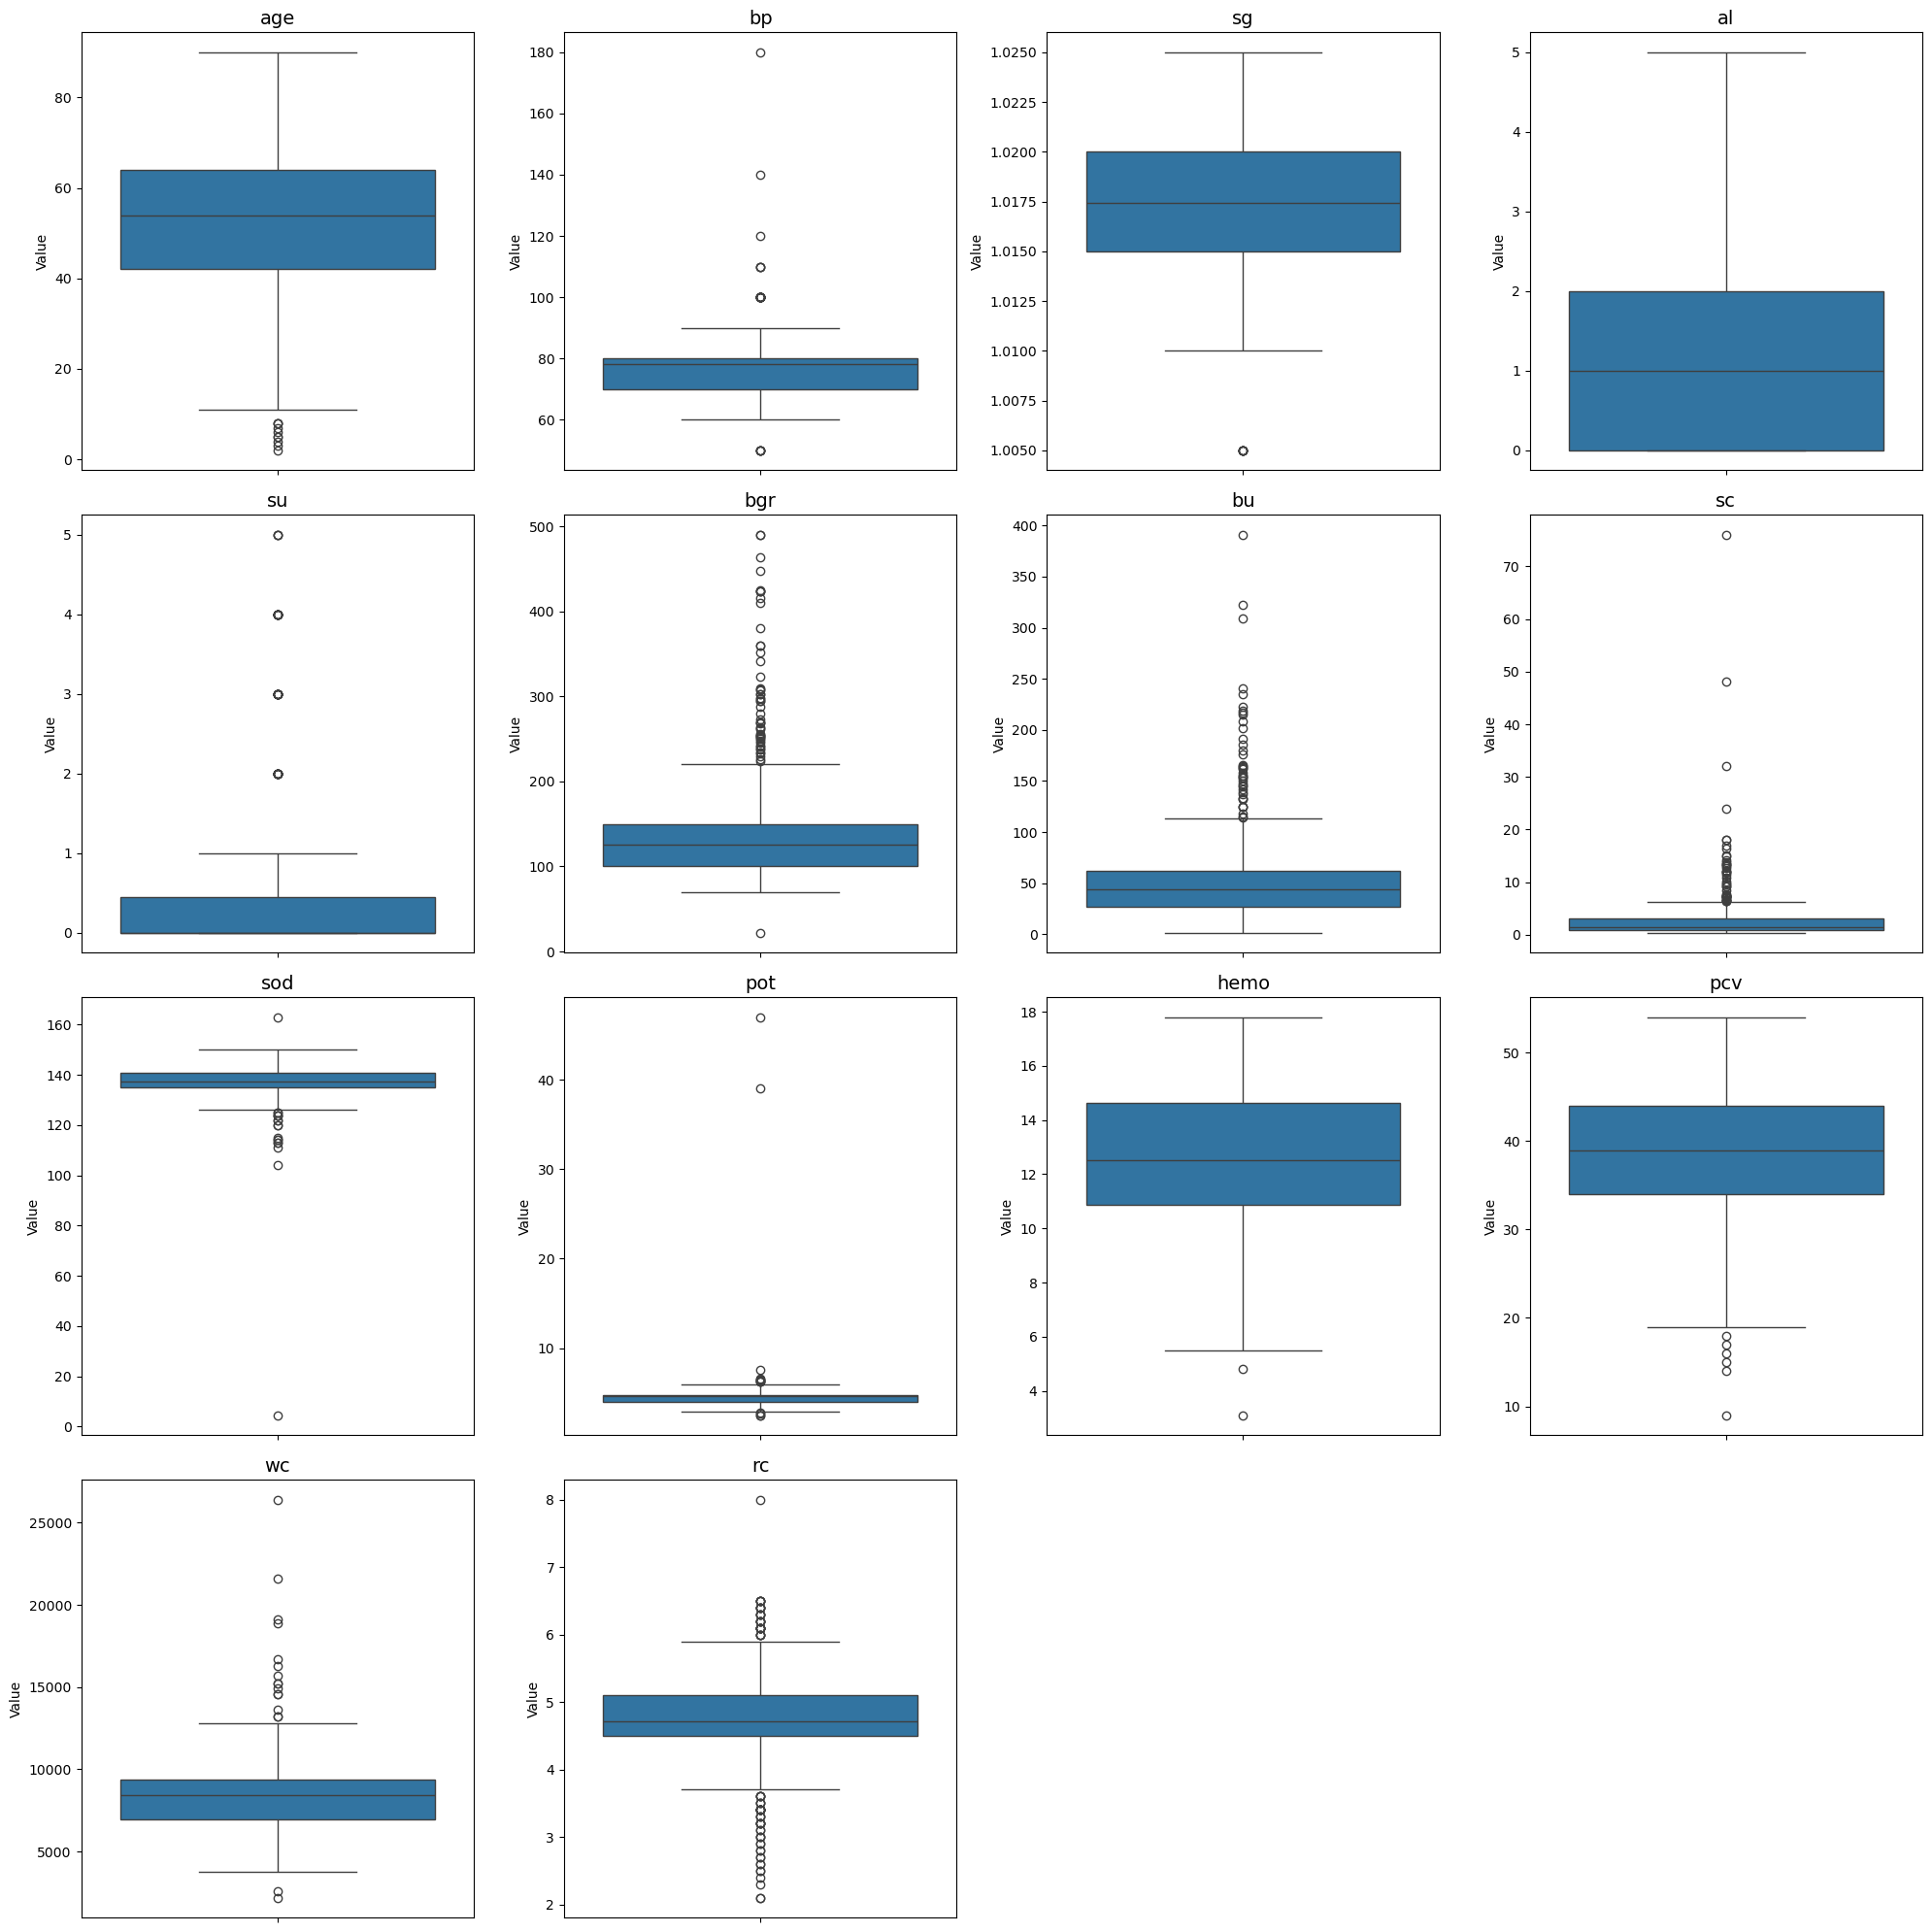

In [17]:
# --- Task 4: Box Plots (Numeric Features) ---
print("--- 4. Generating Box Plots for Numeric Features ---")
n = len(all_numeric_features)
n_cols = 4
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten() # Flatten to 1D array for easy iteration

for i, col in enumerate(all_numeric_features):
    sns.boxplot(data=df_cleaned, y=col, ax=axes[i], orient='v')
    axes[i].set_title(col, fontsize=14)
    axes[i].set_ylabel('Value')

# Hide unused subplots
for i in range(n, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('numeric_boxplots.png')
print("Numeric feature box plots saved as 'numeric_boxplots.png'.")
print("\n" + "="*50 + "\n")

--- 5. Generating Count Plots for Categorical Features ---
--- All tasks complete. ---


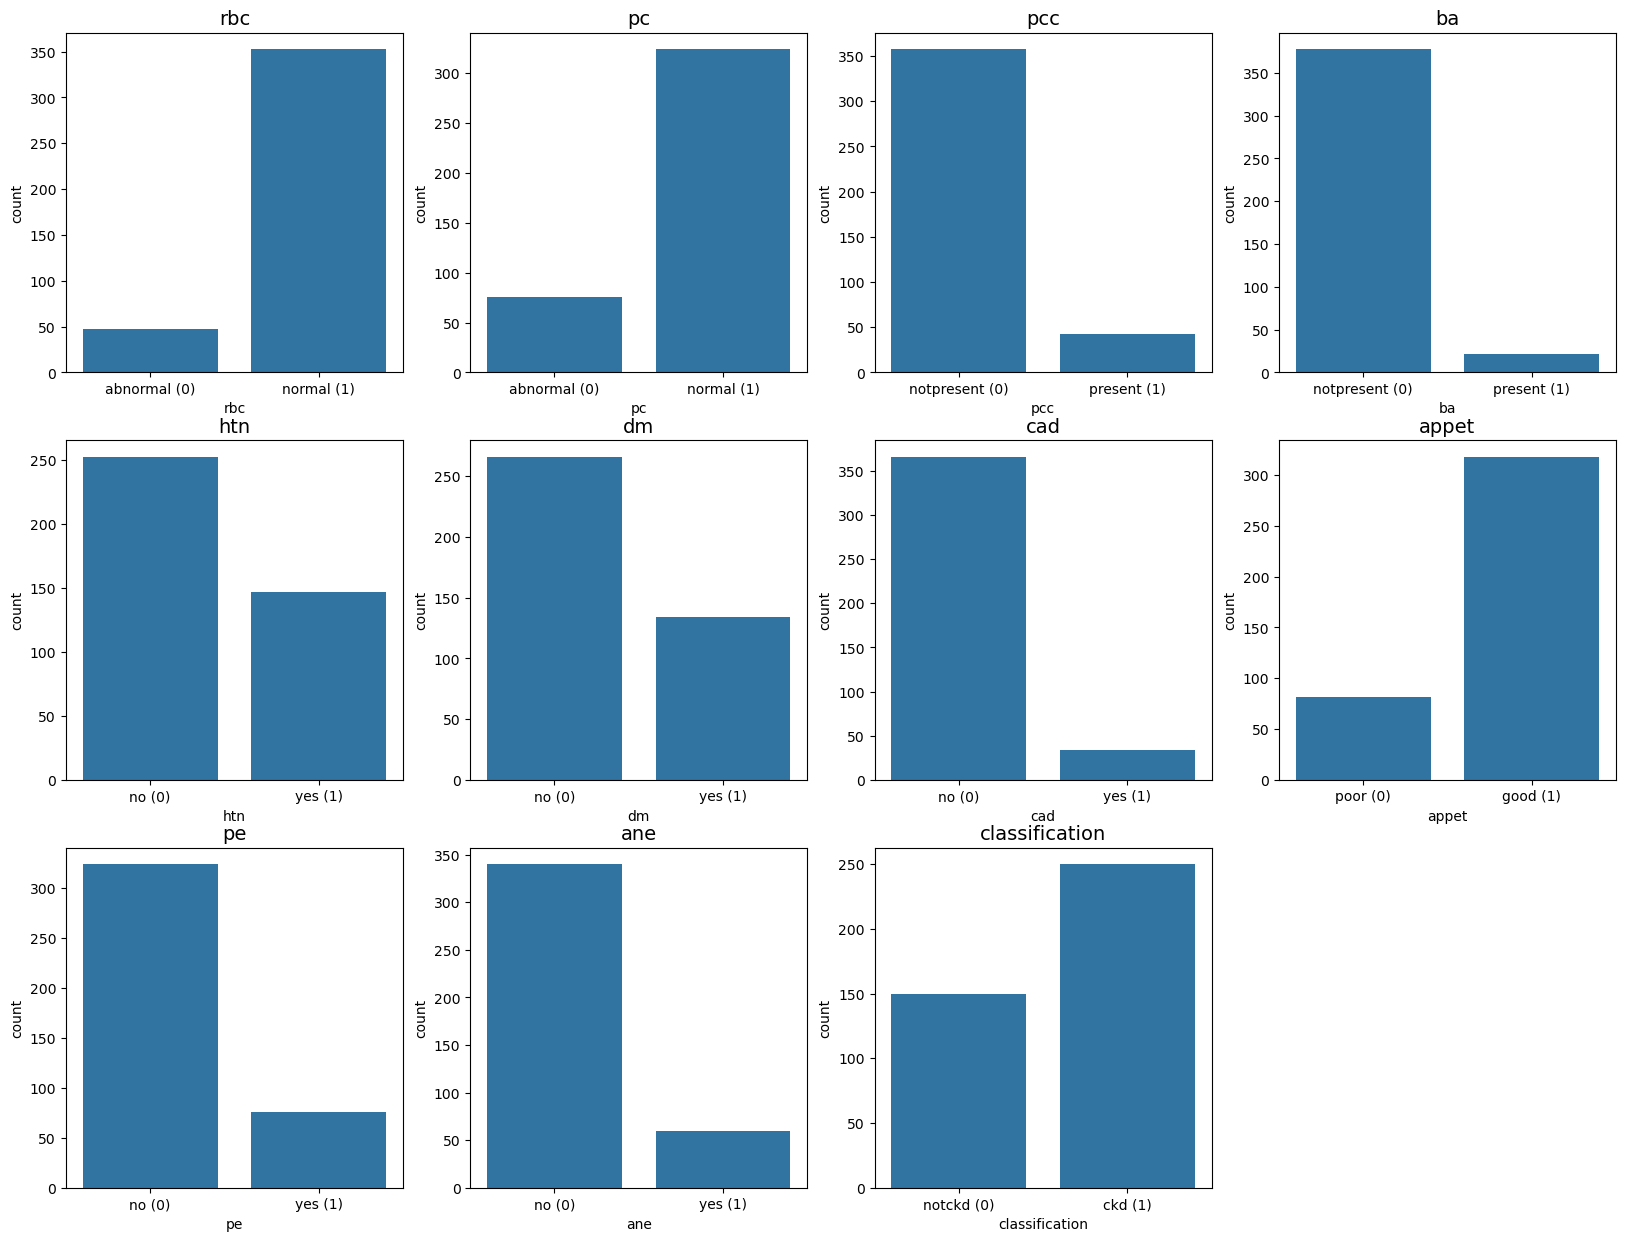

In [18]:
# --- Task 5: Count Plots (Categorical Features) ---
print("--- 5. Generating Count Plots for Categorical Features ---")
n_cat = len(all_categorical_features)
n_cols_cat = 4
n_rows_cat = math.ceil(n_cat / n_cols_cat)

fig_cat, axes_cat = plt.subplots(n_rows_cat, n_cols_cat, figsize=(20, 5 * n_rows_cat))
axes_cat = axes_cat.flatten()

# Define the labels based on our manual mapping
label_map = {
    'rbc': ['abnormal (0)', 'normal (1)'],
    'pc': ['abnormal (0)', 'normal (1)'],
    'pcc': ['notpresent (0)','present (1)'],
    'ba': ['notpresent (0)', 'present (1)'],
    'htn': ['no (0)', 'yes (1)'],
    'dm': ['no (0)', 'yes (1)'],
    'cad': ['no (0)', 'yes (1)'],
    'appet': ['poor (0)', 'good (1)'],
    'pe': ['no (0)', 'yes (1)'],
    'ane': ['no (0)', 'yes (1)'],
    'classification': ['notckd (0)', 'ckd (1)']
}

for i, col in enumerate(all_categorical_features):
    if col in df_cleaned.columns:
        # Ensure 'order' argument uses sorted list of unique integer values
        order = sorted(df_cleaned[col].dropna().unique())
        sns.countplot(data=df_cleaned, x=col, ax=axes_cat[i], order=order)
        axes_cat[i].set_title(col, fontsize=14)
        
        # Set custom labels
        if col in label_map:
            try:
                # Get current tick positions (e.g., 0, 1)
                current_ticks = sorted([int(tick) for tick in order])
                # Map positions to new labels
                new_labels = [label_map[col][tick_val] for tick_val in current_ticks if tick_val in [0, 1]]
                if new_labels:
                    axes_cat[i].set_xticks(current_ticks)
                    axes_cat[i].set_xticklabels(new_labels, rotation=0)
            except Exception as e:
                # Fallback if ticks aren't as expected
                print(f"Could not apply labels for {col}: {e}")
                pass

# Hide unused subplots
for i in range(n_cat, len(axes_cat)):
    axes_cat[i].set_visible(False)

# plt.tight_layout()
# plt.savefig('categorical_countplots.png')
# print("Categorical feature count plots saved as 'categorical_countplots.png'.")
# print("\n" + "="*50 + "\n")

print("--- All tasks complete. ---")